# `Hyperopt` and the Chicago crime data set

## Setup for `Google Colab`

These scripts are probably going to run for a *good* while - so we want to use possibly better hardware. Thanks to our `Google Overlords` we can play with their toys.

First clone the repo, to give `Google Colab` access to the scripts:

!git clone https://github.com/thsis/INFOSYS.git

Install required packages in the specified versions:

!pip3 install -r requirements.txt

Execute `preprocessing/crime_preprocessing.py` to generate the files `data/crime_total.csv` and `data/crime_district.csv`.

!python3 preprocessing/crime_preprocessing.py

---

In [1]:
import os
import json

import numpy as np
import pandas as pd

from keras.layers import SimpleRNN, LSTM, GRU
from models.recurrent import Recurrent

from sklearn.metrics import mean_squared_error
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
from matplotlib import pyplot as plt

Using TensorFlow backend.


---

## Crime Data

This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to end of October 2018.

Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

The dataset is readily obtainable under [data.gov](https://catalog.data.gov/dataset/crimes-2001-to-present-398a4).

We look at two distinct questions:
1. Can we accurately predict the development of the **whole** time series for the city of Chicago?
2. Can we accurately predict the development of the series for **each district**?

### Load the full series:

The full series contains a single column of summed up incidents per day. We also parse the dates inside the `date` column and set them as the index of the `DataFrame`.

In [2]:
datapath_whole = os.path.join("data", "crime_total.csv")
whole = pd.read_csv(datapath_whole, index_col=["date"],
                    dtype={"crimes_total": np.float32},
                    parse_dates=["date"])
whole.head()

,crimes_total
date,
2001-01-01,1814.0
2001-01-02,1143.0
2001-01-03,1151.0
2001-01-04,1166.0
2001-01-05,1267.0


### Load the series by district:

Here we also parse the dates inside the `Date` column and specify a `MultiIndex` where the levels are `Date` and then `District`. This allows our `models.recurrent`-class to distinguish between the series for the whole of Chicago and the Chicago crime series by each district.

In [3]:
datapath_district = os.path.join("data", "crimes_district.csv")
district = pd.read_csv(datapath_district, index_col=["Date", "District"],
                       dtype={"District": object,
                              "Incidents": np.float32},
                       parse_dates=["Date"])
district.sort_index().head(24).T

Date      2001-01-01                                                      \
District        1.0    2.0    3.0   4.0   5.0   6.0   7.0    8.0    9.0    
Incidents       37.0  110.0  103.0  96.0  95.0  84.0  83.0  111.0  109.0   

Date             ...                                                         \
District    10.0 ...   16.0  17.0  18.0  19.0  20.0 21.0  22.0  24.0   25.0   
Incidents  104.0 ...   67.0  67.0  72.0  72.0  40.0  0.0  61.0  59.0  120.0   

Date            
District  31.0  
Incidents  0.0  

[1 rows x 24 columns]

### Separate data and a holdout set.

Because we use a library that tunes parameters with regards to the test set, we need to separate a holdout set. On this set, which we will not expose to our models we can evaluate the performance of our tuned models.

In [4]:
cutoff = pd.to_datetime("2018-10-01")
whole_data = whole.loc[whole.index < cutoff]
whole_holdout = whole.loc[whole.index >= cutoff]

# As always with MultiIndices, things are a little more complicated.
district_data = district.loc[district.index.map(lambda x: x[0] < cutoff)]
district_holdout = district.loc[district.index.map(lambda x: x[0] > cutoff)]

Check if we did not, by accident, create *views* on the data. We explicitly want *copies*.

In [5]:
assert not whole_data.values.base is whole.values.base
assert not district_data.values.base is district.values.base

---

## Hyperopt parameter spaces

Most of our models have similar parameters which we want to tune. For the sampling of the subspace we use mostly uniform distributions, since they impose the least a-priori assumptions on where the optimal parameters lie.

In [6]:
# add optimizer, learn-rate, 
paramspace = {"maxlag": scope.int(hp.quniform("maxlag", 1, 3, 1)),
              "cell_neurons": scope.int(hp.quniform("cell_neurons", 1, 30, 1)),
              "batch_size": scope.int(hp.quniform("batch_size", 1, 10, 1)),
              "optimizer": hp.choice("optimizer", ["adam", "sgd"])}

We have defined a base parameter space dictionary which we update with the parameters which are more specific to each cell. This can get out of hand pretty fast, therefore we generate a dictionary through a loop:

In [7]:
spacesdict ={}
for cell in (SimpleRNN, LSTM, GRU):
    spacesdict[cell.__name__] = {"cell": cell, **paramspace}

pprint(spacesdict)

{'GRU': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f417930b278>,
         'cell': <class 'keras.layers.recurrent.GRU'>,
         'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f417930b048>,
         'maxlag': <hyperopt.pyll.base.Apply object at 0x7f417930b208>,
         'optimizer': <hyperopt.pyll.base.Apply object at 0x7f4179305128>},
 'LSTM': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f417930b278>,
          'cell': <class 'keras.layers.recurrent.LSTM'>,
          'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f417930b048>,
          'maxlag': <hyperopt.pyll.base.Apply object at 0x7f417930b208>,
          'optimizer': <hyperopt.pyll.base.Apply object at 0x7f4179305128>},
 'SimpleRNN': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f417930b278>,
               'cell': <class 'keras.layers.recurrent.SimpleRNN'>,
               'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f417930b048>,
               'maxlag': <hyperopt.pyll.base.Ap

In order to store the results of each `hyperopt`-search we can create a `hyperopt.Trials`-object, which is very similar to a native Python `dictionary`. And because we want to fit *three* models on *two* different datasets and are too lazy to type *six* times virtually the same code we user a dictionary comprehension.

In [8]:
trialsdict = {key: {model: Trials() for model in ("SimpleRNN", "LSTM", "GRU")} for key in ("whole", "district")}
pprint(trialsdict)

{'district': {'GRU': <hyperopt.base.Trials object at 0x7f4179292358>,
              'LSTM': <hyperopt.base.Trials object at 0x7f4179292470>,
              'SimpleRNN': <hyperopt.base.Trials object at 0x7f4179292400>},
 'whole': {'GRU': <hyperopt.base.Trials object at 0x7f4179292908>,
           'LSTM': <hyperopt.base.Trials object at 0x7f4179292080>,
           'SimpleRNN': <hyperopt.base.Trials object at 0x7f41792924a8>}}


---

## Optimizing over the parameter space

We could of course write an objective function and a separate call to `hyperopt.fmin` for each of the three model-classes per dataset, which would result in 12 different function calls - this is way too tedious and prone to errors.

That's why we will use the `Python`-decorator syntax. We first define a second order function that contains the part of `hyperopt` that minimizes objective functions and which will in turn expect a function as its only argument.

In [9]:
def minimizer(objective):
    def outer(paramspace, trials, max_evals=3):
        pbar = tqdm(total=max_evals, desc=paramspace["cell"].__name__)
        def inner(*args, **kwargs):
            pbar.update()
            return objective(*args, **kwargs)

        best = fmin(fn=inner,
                    space=paramspace,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        pbar.close()
        return best
    return outer

And now to the function we wish to decorate. It contains 3 steps:
1. Create a model with a certain set of (yet undefined) parameters.
2. Train the model.
3. Calculate the loss on a test set and return a dictionary, that contains the loss and a flag indicating that everything went okay.

We do this for the whole series:

In [10]:
@minimizer
def whole_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(whole_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

And for the series by district:

In [11]:
@minimizer
def district_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(district_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

And now to tuning the hyperparameters. Again we pass through all our models for each dataset and store the best hyperparameters in a dictionary.

In [12]:
models = ("SimpleRNN", "LSTM", "GRU")
best = {"whole": {},
        "district": {}}

for model in models:
    best["whole"][model] = whole_get_loss(spacesdict[model], 
                                          trialsdict["whole"][model])
    best["district"][model] = district_get_loss(spacesdict[model],
                                                trialsdict["district"][model])

In [21]:
pprint(best)

{'district': {'GRU': {'batch_size': 7.0,
                      'cell_neurons': 30.0,
                      'maxlag': 2.0,
                      'optimizer': 0},
              'LSTM': {'batch_size': 7.0,
                       'cell_neurons': 3.0,
                       'maxlag': 2.0,
                       'optimizer': 0},
              'SimpleRNN': {'batch_size': 6.0,
                            'cell_neurons': 14.0,
                            'maxlag': 3.0,
                            'optimizer': 0}},
 'whole': {'GRU': {'batch_size': 1.0,
                   'cell_neurons': 21.0,
                   'maxlag': 3.0,
                   'optimizer': 1},
           'LSTM': {'batch_size': 1.0,
                    'cell_neurons': 17.0,
                    'maxlag': 3.0,
                    'optimizer': 1},
           'SimpleRNN': {'batch_size': 5.0,
                         'cell_neurons': 14.0,
                         'maxlag': 3.0,
                         'optimizer': 1}}}


The reason why we use dictionaries so much is, because we can easily save them as a `json`-file which then in turn can be exported to other programming languages as well (which is much harder if you save your objects as with the `pickle` module).

In [22]:
with open(os.path.join('analysis', 'best_params.json'), 'w') as outfile:
    json.dump(best, outfile)

---

## Visualize the search Process

In [23]:
def plot_trials(trials, paramspace, savepath=None):
    """Plot path of hyperopt-search for analysis."""
    parameters = [k for k in paramspace.keys() if k != "cell"]
    cols = len(parameters)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 5), sharey=True)

    for i, val in enumerate(parameters):
        xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
        ys = [t['result']['loss'] for t in trials.trials]
        xs, ys = zip(*sorted(zip(xs, ys)))
        axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25)
        axes[i].set_title(val)
        axes[i].set_ylim([0, 0.002])
        
    fig.suptitle("Hyperopt-path for {}".format(paramspace["cell"].__name__))
    if savepath:
        fig.savefig(savepath)

    return fig, axes

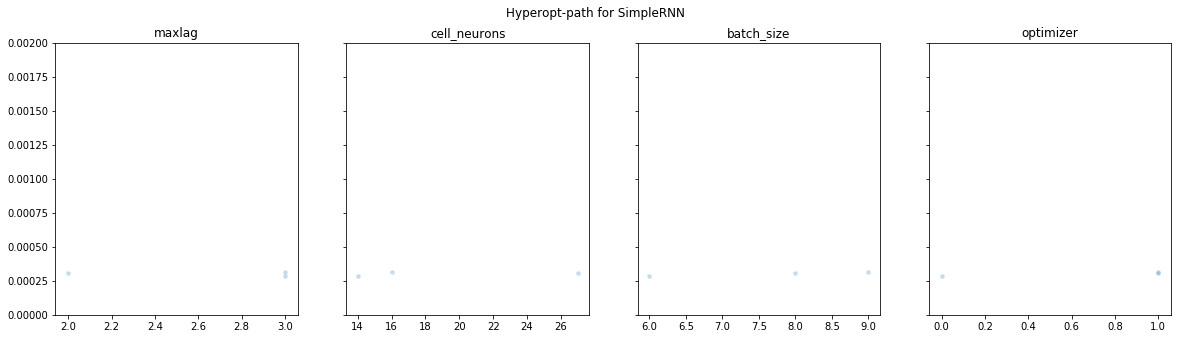

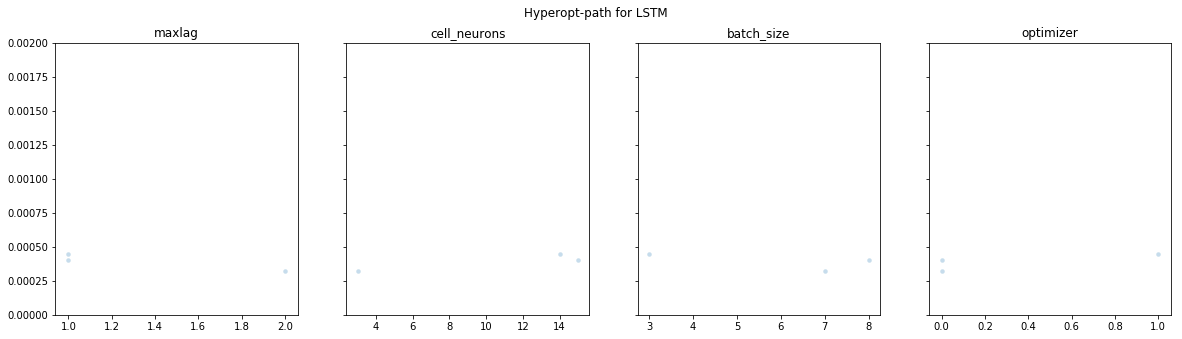

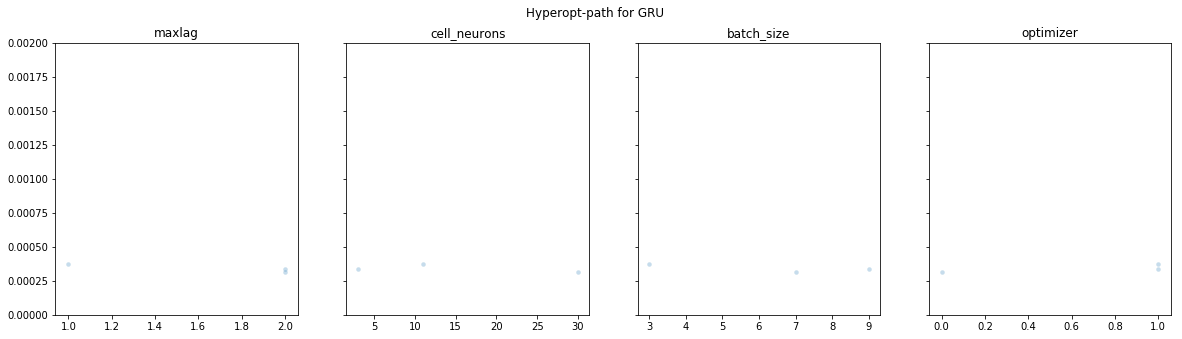

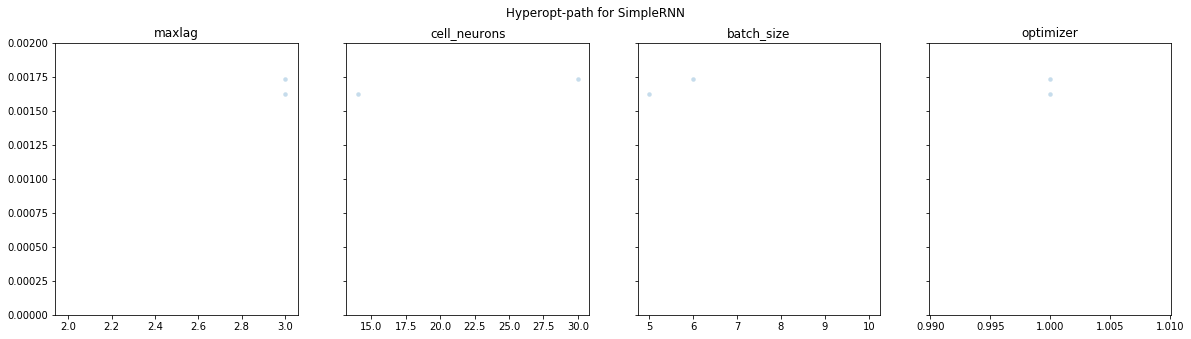

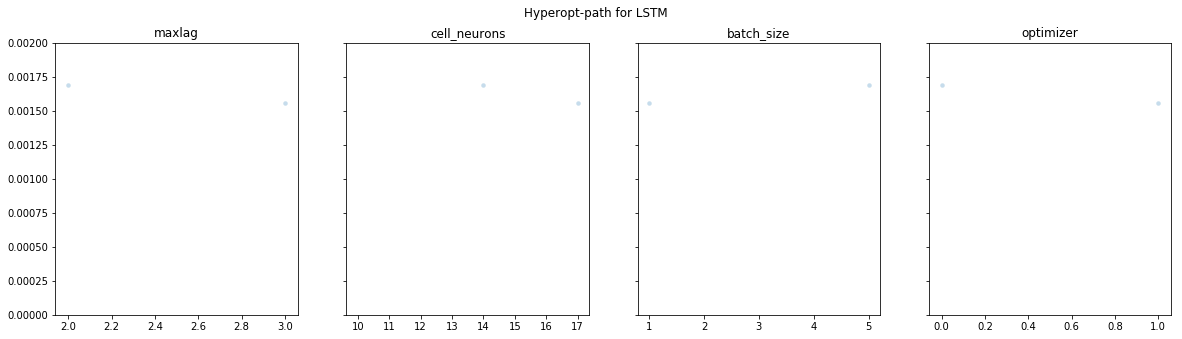

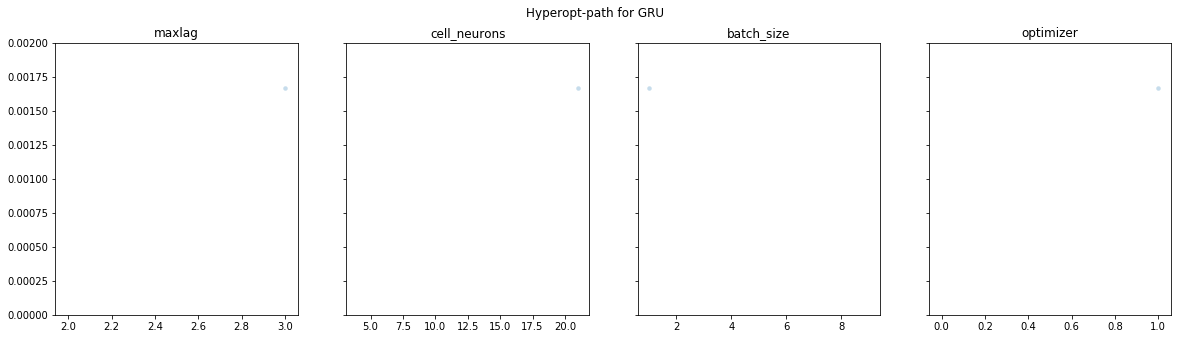

In [24]:
for series in "district", "whole":
    for model in "SimpleRNN", "LSTM", "GRU":
        filename = series + "-hyperopt-" + model + ".png"
        plot_trials(paramspace=spacesdict[model],
                    trials=trialsdict[series][model],
                    savepath=os.path.join("analysis", filename))

In [25]:
def typecast(params):
    out = {}
    optimizers = ["adam", "sgd"]
    for key, val in params.items():
        if key == "optimizer":
            out[key] = optimizers[val]
        else:
            try:
                out[key] = int(val)
            except TypeError:
                out[key] = val
    return out

For the validation on the holdout set, we can compute the proportion of timestamps that exist in the data before our cutoff point and use the remainder for the new test set.

In [26]:
train_size = whole.index.get_loc(cutoff) /len(whole.index.unique())

In [34]:
name2cell = {"RNN": SimpleRNN,
             "LSTM": LSTM,
             "GRU": GRU}
series2data = {"whole": whole, "district": district}
series_col = []
cell_col = []
loss_col = []

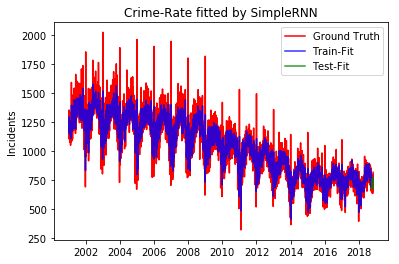

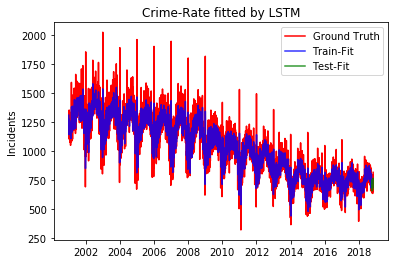

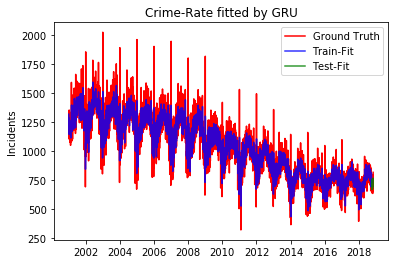

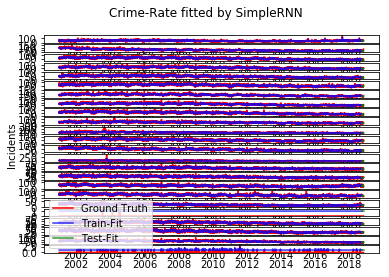

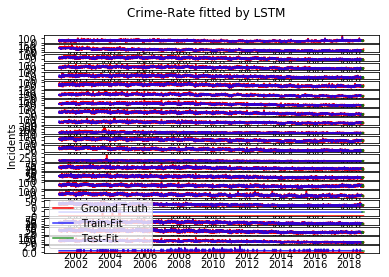

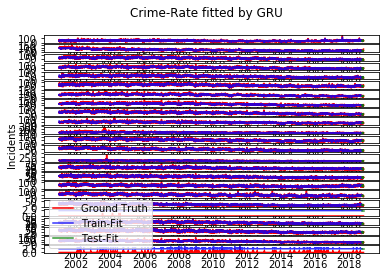

In [35]:
for series, data in tqdm(series2data.items()):
    for name, cell in tqdm(name2cell.items()):
        bestparams = typecast({"cell": cell,
                               **best[series][cell.__name__]})
        
        model = Recurrent(data, epochs=3, train_size=train_size,
                          **bestparams, verbose=False)
        model.train()
        
        path = os.path.join("analysis", "best_" + name)
        model.plot_fit(savepath=path) 
        predictions = model.forecast(model.X_test)
        loss = mean_squared_error(y_true=model.y_test,
                                  y_pred=predictions)
        series_col.append(series)
        cell_col.append(name)
        loss_col.append(loss)

In [36]:
validation = pd.DataFrame({"Series": series_col,
                           "Model": cell_col,
                           "Validation Loss": loss_col})
validation.set_index(["Series", "Model"]).T

Series              whole                      district                    
Model                 RNN      LSTM       GRU       RNN      LSTM       GRU
Validation Loss  0.001035  0.000935  0.000983  0.000278  0.000305  0.000312